In [1]:
! pip install open_clip_torch
! pip install --upgrade datasets
! pip install relplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pathlib

import datasets
import matplotlib.pyplot as plt
import numpy as np
import open_clip
import PIL.Image
import PIL.PngImagePlugin
import relplot
import scipy.special
import sklearn.calibration
import sklearn.isotonic
import sklearn.metrics
import torch

PIL.PngImagePlugin.MAX_TEXT_CHUNK = 100 * (1024**2)

In [4]:
# Datasets
DATASET_URLS = {
    "llama-test": "https://drive.google.com/uc?id=1pop_ltmF9mpiMDqi1lcTbpmOyTo96if1",
    "llama-train": "https://drive.google.com/uc?id=1Wyc8U_I2UCjT863ndpDfhgSLxjfArk3A",
    "beach-train": "https://drive.google.com/uc?id=1F6ozO15919KpPP_57Z0jD5dHOqU_w-nb",
    "beach-test": "https://drive.google.com/uc?id=1o5MpdWKKrC80I4zbJr9u2L_zKPUXdQgy",
    "beach-test-ood": "https://drive.google.com/uc?id=163NyfmWarIAAOjUqH3QPedQokzfmNoFH",
}

In [6]:
for dataset_name, dataset_gdrive_url in DATASET_URLS.items():
    ! gdown {dataset_gdrive_url}
    ! unzip /content/{dataset_name}.zip

Downloading...
From (original): https://drive.google.com/uc?id=1pop_ltmF9mpiMDqi1lcTbpmOyTo96if1
From (redirected): https://drive.google.com/uc?id=1pop_ltmF9mpiMDqi1lcTbpmOyTo96if1&confirm=t&uuid=151fafba-d27a-487c-95fe-575a55ea8108
To: /content/llama-test.zip
100% 50.0M/50.0M [00:01<00:00, 34.1MB/s]
Archive:  /content/llama-test.zip
   creating: llama-test/
  inflating: llama-test/state.json   
  inflating: llama-test/dataset_info.json  
  inflating: llama-test/data-00000-of-00001.arrow  
Downloading...
From (original): https://drive.google.com/uc?id=1Wyc8U_I2UCjT863ndpDfhgSLxjfArk3A
From (redirected): https://drive.google.com/uc?id=1Wyc8U_I2UCjT863ndpDfhgSLxjfArk3A&confirm=t&uuid=da49ea13-9f23-41c1-aa89-5e65e4ddadbb
To: /content/llama-train.zip
100% 1.28G/1.28G [00:23<00:00, 54.2MB/s]
Archive:  /content/llama-train.zip
   creating: llama-train/
  inflating: llama-train/state.json  
  inflating: llama-train/dataset_info.json  
  inflating: llama-train/data-00002-of-00003.arrow  
  inf

In [92]:
class ZeroShotClassifier:
    """Wrapper for loading and running zero-shot image classifiers."""

    TEMPLATES = [
        "itap of a {}.",
        "a bad photo of the {}.",
        "a origami {}.",
        "a photo of the large {}.",
        "a {} in a video game.",
        "art of the {}.",
        "a photo of the small {}.",
    ]

    def __init__(self, model_name, pretrained_source, device):
        self.model_name = model_name
        self.pretrained_source = pretrained_source
        self.device = device
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(
            self.model_name,
            pretrained=self.pretrained_source,
        )
        self.model.eval().to(device)
        self.tokenizer = open_clip.get_tokenizer(self.model_name)
        self.text = None
        self.text_features = None

    def set_text(self, text):
        self.text = text
        tokens = self.tokenizer([t.format(self.text) for t in ZeroShotClassifier.TEMPLATES])
        with torch.no_grad(), torch.amp.autocast("cuda"):
            text_features = self.model.encode_text(tokens.to(self.device))
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_features = text_features.mean(dim=0)
            text_features /= text_features.norm()
        self.text_features = text_features.to("cpu").numpy()

    def get_image_features(self, image: PIL.Image.Image):
        input_features = self.preprocess(image).unsqueeze(0)
        with torch.no_grad(), torch.amp.autocast("cuda"):
            image_features = self.model.encode_image(input_features.to(self.device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features.to("cpu").numpy()

    def get_image_features_batch(self, images):
        input_features = torch.stack([self.preprocess(im) for im in images])
        with torch.no_grad(), torch.amp.autocast("cuda"):
            image_features = self.model.encode_image(input_features.to(self.device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features.cpu().numpy()

    def score_image(self, image: PIL.Image.Image, with_features: bool = False):
        image_features = self.get_image_features(image)
        score = (image_features @ self.text_features).item()
        results = {"score": score.astype(np.float32)}
        if with_features:
            results["features"] = image_features
        return results

    def score_image_batch(self, images, with_features=False):
        image_features = self.get_image_features_batch(images)
        scores = image_features @ self.text_features
        results = {"score": scores.astype(np.float32)}
        if with_features:
            results["features"] = image_features
        return results

class BaseCalibrator:
    """Base class for score calibration methods."""

    def fit(self, scores: np.ndarray, labels: np.ndarray):
        """Train the calibrator."""
        raise NotImplementedError

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        """Calibrate scores into probabilities."""
        raise NotImplementedError


class IsotonicCalibrator(BaseCalibrator):
    """Calibrates scores using isotonic regression."""

    def __init__(self) -> None:
        self.calibrator = sklearn.isotonic.IsotonicRegression(out_of_bounds="clip")

    def fit(self, scores: np.ndarray, labels: np.ndarray) -> "IsotonicCalibrator":
        """Fit the isotonic calibrator."""
        self.calibrator.fit(scores, labels)
        return self

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        """Apply isotonic calibration to scores."""
        return self.calibrator.predict(scores)


class SigmoidCalibrator(BaseCalibrator):
    """Calibrates scores using sigmoid/Platt scaling."""

    def __init__(self) -> None:
        self.calibrator = sklearn.calibration._SigmoidCalibration() # brittle

    def fit(self, scores: np.ndarray, labels: np.ndarray) -> "SigmoidCalibrator":
        """Fit the sigmoid calibrator"""
        self.calibrator.fit(scores, labels)
        return self

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        """Apply sigmoid calibration to scores."""
        return self.calibrator.predict(scores)


class SimilarityBinningAveragingCalibrator(BaseCalibrator):
    """Calibrates scores using Similarity-Binning Averaging calibration."""

    def __init__(self, k: int=10, alpha: float=0.95, inner_calibration_class: BaseCalibrator=SigmoidCalibrator) -> None:
        """Create a new instance of the SBA calibrator.

        k: number of nearest neighbors in the bin to average over
        alpha: weighting factor between CLIP features and class probs for similarity
        inner_calibration_class: method for getting calibrated scores from calibration data
        """
        self.k = k
        self.alpha = alpha
        self.inner_calibrator = inner_calibration_class()
        self._train_features = None
        self._train_probs = None

    def fit(self, scores: np.ndarray, labels: np.ndarray, features: np.ndarray) -> "SigmoidCalibrator":
        """Fit the sigmoid calibrator"""
        self.inner_calibrator.fit(scores, labels)
        self._train_features = features
        self._train_probs = self.inner_calibrator.predict_proba(scores)
        return self

    def predict_proba(self, scores: np.ndarray, features: np.ndarray) -> np.ndarray:
        """Apply sigmoid calibration to scores."""
        feature_similarities = features @ self._train_features.T
        fs_max = feature_similarities.max()
        fs_min = feature_similarities.min()
        feature_similarities = (feature_similarities - fs_min) / fs_max
        probs = self.inner_calibrator.predict_proba(scores)
        probs_similarities = 1 - np.abs(probs[:, np.newaxis] - self._train_probs)
        similarities = self.alpha * feature_similarities + (1 - self.alpha) * probs_similarities
        top_k_indices = np.argsort(-similarities, axis=1)[:, :self.k]
        top_k_probs = self._train_probs[top_k_indices]
        return top_k_probs.mean(axis=1)

In [93]:
def build_scores_dataset(zero_shot_classifier, image_dataset, batch_size=32, with_features=False):
    scores_dataset = image_dataset.map(
        lambda examples: dict(
            label=examples["label"],
            **zero_shot_classifier.score_image_batch(examples["image"], with_features)
        ),
        remove_columns=["image"],
        batched=True,
        batch_size=batch_size,
    )
    scores_dataset.set_format(type="numpy", columns=["features",])
    return scores_dataset

Calibration results for 'beach' with sigmoid calibration
Brier score: 0.0332
smECE: 0.0644


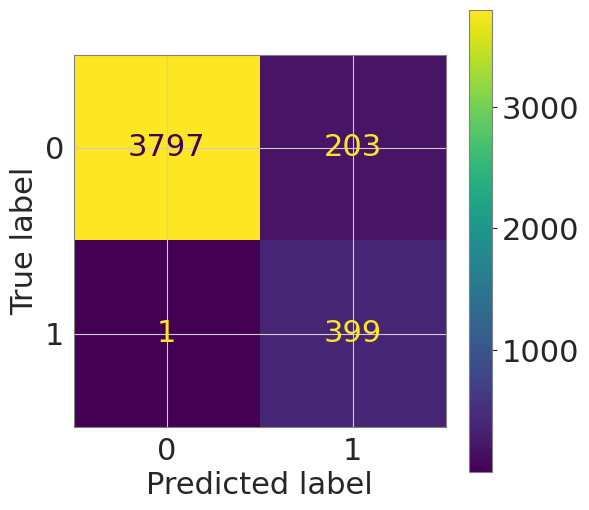

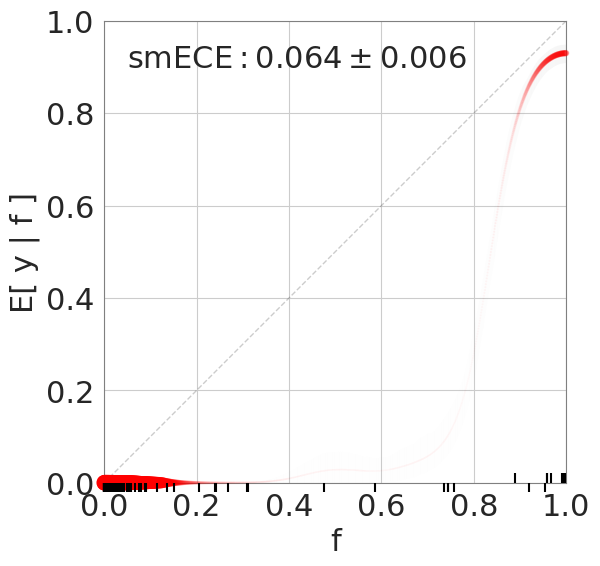

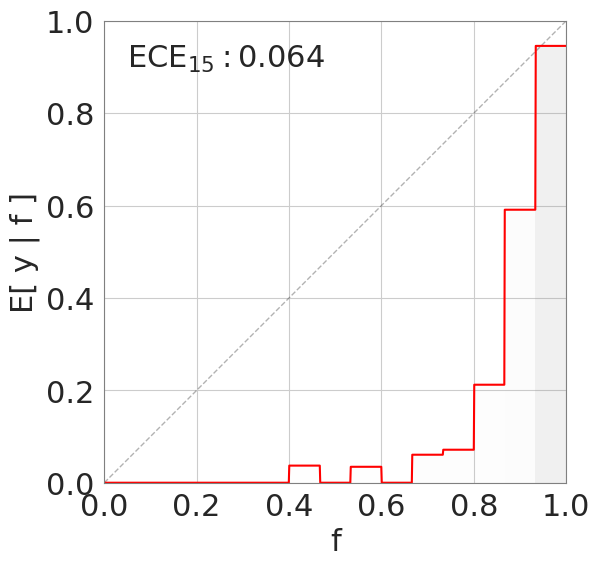

Calibration results for 'beach' with isotonic calibration
Brier score: 0.0371
smECE: 0.0660


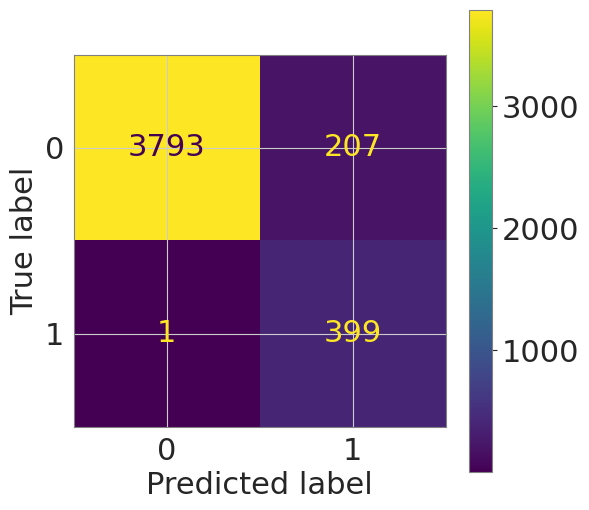

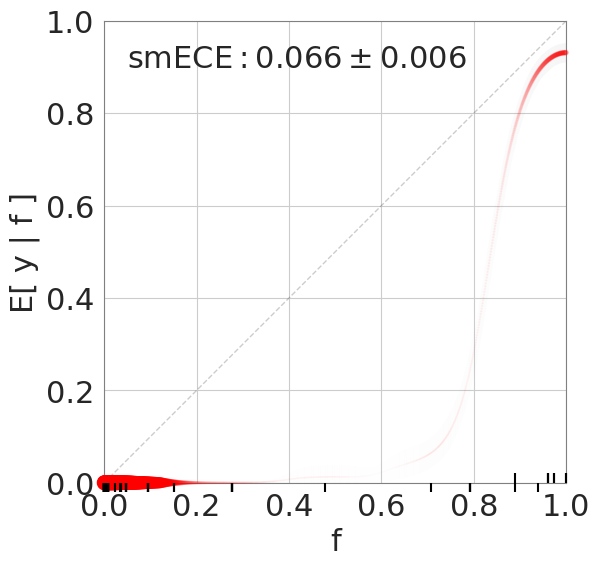

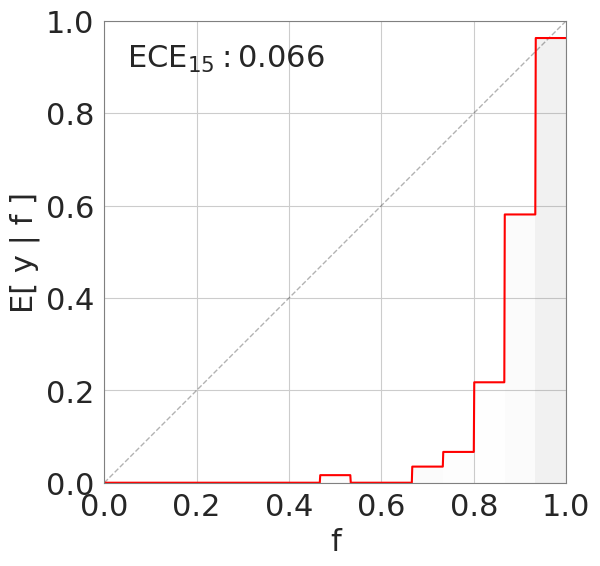

Calibration results for 'beach' with sba calibration
Brier score: 0.0280
smECE: 0.0667


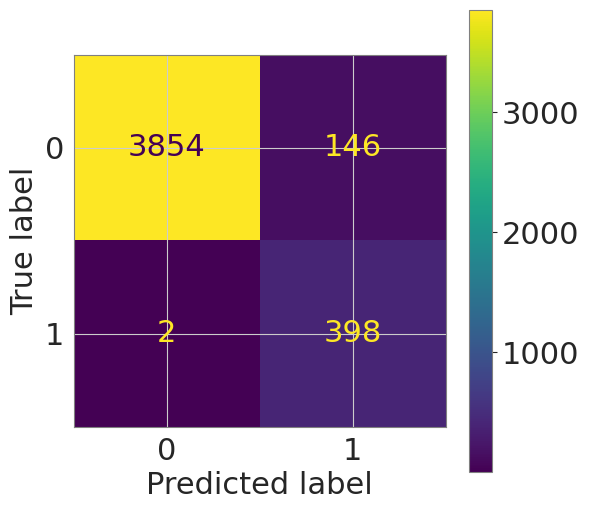

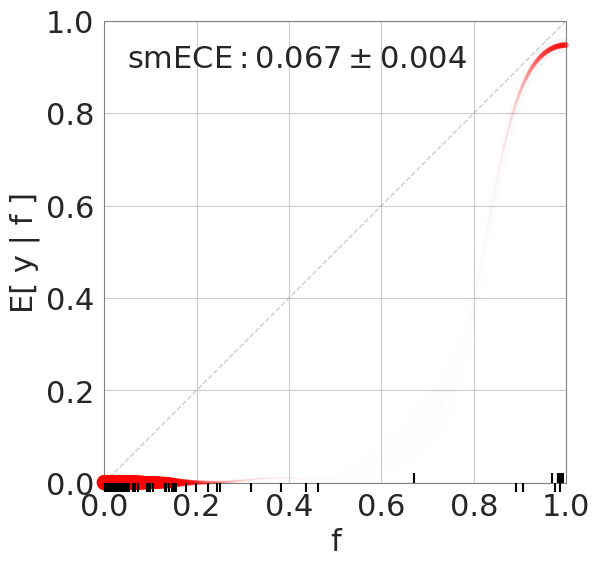

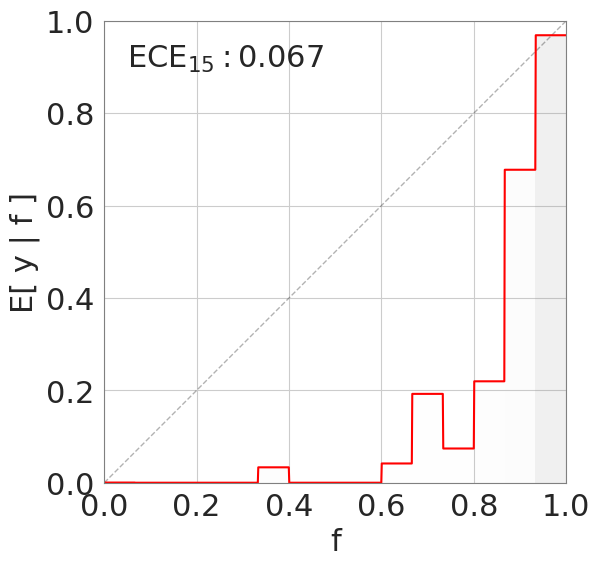

In [94]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
zsc = ZeroShotClassifier("ViT-B-32-quickgelu", "openai", device)
#zsc = ZeroShotClassifier("ViT-B-16-SigLIP", "webli")
labels = ["beach"]
for label in labels:
    zsc.set_text(label)

    train_image_dataset_path = pathlib.Path(f"/content/{label}-train")
    train_image_dataset = datasets.load_from_disk(train_image_dataset_path)
    train_scores_dataset = build_scores_dataset(zsc, train_image_dataset, batch_size=batch_size, with_features=True)

    test_image_dataset_path = pathlib.Path(f"/content/{label}-test-ood")
    test_image_dataset = datasets.load_from_disk(test_image_dataset_path)
    test_scores_dataset = build_scores_dataset(zsc, test_image_dataset, batch_size=batch_size, with_features=True)

    calibration_methods = ["sigmoid", "isotonic", "sba"]
    for calibration_method in calibration_methods:
        if calibration_method == "sigmoid":
            calibrator = SigmoidCalibrator()
            calibrator.fit(train_scores_dataset["score"], train_scores_dataset["label"])
            probs = calibrator.predict_proba(test_scores_dataset["score"])
        elif calibration_method == "isotonic":
            calibrator = IsotonicCalibrator()
            calibrator.fit(train_scores_dataset["score"], train_scores_dataset["label"])
            probs = calibrator.predict_proba(test_scores_dataset["score"])
        elif calibration_method == "sba":
            calibrator = SimilarityBinningAveragingCalibrator()
            calibrator.fit(train_scores_dataset["score"], train_scores_dataset["label"], train_scores_dataset["features"])
            probs = calibrator.predict_proba(test_scores_dataset["score"], test_scores_dataset["features"])

        print(f"Calibration results for '{label}' with {calibration_method} calibration")
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_scores_dataset["label"], probs > 0.5)
        brier_score = sklearn.metrics.brier_score_loss(test_scores_dataset["label"], probs)
        print(f"Brier score: {brier_score:.4f}")
        sm_ece = relplot.smECE(probs, test_scores_dataset["label"])
        print(f"smECE: {sm_ece:.4f}")
        relplot.rel_diagram(probs, test_scores_dataset["label"])
        plt.show()
        relplot.rel_diagram_binned(probs, test_scores_dataset["label"])
        plt.show()